# Probabilistic Programming - A Powerful Abstraction

This notebook introduces the reader to the concept of probabilistic programming, an effort to construct programming systems in which Bayesian inference is at the core of the scientific endeavour. Integrations with machine learning frameworks are another core concept, when considering data-driven (amortized) inference routines. The amortized inference showcase of Gen's capabilities is based on Gen's excellent introduction to [Data-Driven Proposals in Gen](https://github.com/probcomp/gen-quickstart/blob/master/tutorials/Data-Driven%20Proposals%20in%20Gen.ipynb).


## Outline:

**Section 1.** [Introduction to Probabilistic Programming](#probprog)

**Section 2.** [Architecture of Gen](#gen)

**Section 3.** [Core-Abstractions of Gen](#abstractions)

**Section 4.** [Data-Driven Proposals in Gen](#datadriven)

<img src="imgs/PPX.png" width="700" height="300" />

(Source: Etalumis: Bringing Probabilistic Programming to Scientific Simulators at Scale)

## 1: Introduction to Probabilistic Programming <a name="probprog"></a>

### What is Probabilistic Programming?

- Emerging paradigm to express probabilistic models in a generic programming language
- Native reasoning about probabilities and uncertainties in our models
- Semantics of Bayesian inference
- Most often acts as a compiler between the domain-specific probabilistic programming language and the generic programming language it is built on top of
- Translate inference problems from the generic programming language or a DSL into mathematical object to which probabilistic inference can be applied via
    - Language design
    - Interpreters
    - Compilers
- The main applications are currently
    - Machine learning, especially Bayesian deep learning
    - Computer vision
    - Robotics
    - Uncertainty quantification

### What is the inherent Problem of Bayesian Inference?

Recall Bayes rule:

$p(x|y) = \frac{p(x, y)}{\int p(x, y) dx}$

e.g.

$= \frac{\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} x^{y + \alpha - 1} \left( 1 - x \right)^{\beta - y}}{\int \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} x^{y + \alpha - 1} \left( 1 - x \right)^{\beta - y} dx} = \frac{2}{2}$

Leaving us with an integral, which is in nearly all applications intractable. We hence have to rely on a number of inference algorithms to approximate the denominator and arrive at the posterior.

### The Core of a Probabilistic Programming System: The Inference Library

A core requirement for an inference algorithm to be considered worthwhile including in a probabilistic programming system is its applicability to a large class of models, without the need for the injection of custom code. The inference algorithms in use can largely be split up into two main categories; the sampling-based inference algorithms and the optimization-based algorithms.

Based on optimization:
- Variational inference
- Black-Box Variational Inference (BBVI)
- Automatic Differentiation Variational Inference (ADVI)
- Stochastic Variational Inference (SVI)
- ...

Based on sampling:
- Hamiltonian Monte-Carlo
- Sequential Monte-Carlo
- Gibbs Sampler
- Importance Sampling
- Metropolis-Hastings
- ...

## 2: Architecture of Gen <a name="gen"></a>

An ability inherent to Gen, making it so useful for difficult problems from the natural/physical sciences is its flexible, extensible domain-specific language, which accepts Julia code to then construct the probabilistic programs. Gen's architecture plays a large part in driving these applications forward.

<img src="imgs/GenArchitecture.png" width="750" height="350" />

(Source: Gen: A General-Purpose Probabilistic ProgrammingSystem with Programmable Inference)

With Gen's architecture we are able to seamlessly integrate between neural networks, generative models written in Julia, and an extensive inference library. All, while at the same time still being lightweight and an extensible inference library. If latency is of importance Gen offers a static DSL, which compiles the probabilistic program and hence guarantees the best possible performance while reducing the available expressiveness at the same time. This can be compared to the layout of [Turing](https://github.com/TuringLang/Turing.jl), a second prominent example of probabilistic programming in Julia.

<img src="imgs/TuringArchitecture.png" width="280" height="335" />

A probabilistic programming system in which the user has to write generative models conformal with the DSL at the core of Turing. An advantage that Turing has though is that it seamlessly interfaces with the remaining Julia machine learning ecosystem, such as Flux etc. This allows for the ability to easily construct hierarchical Bayesian models, as could be seen in the 'regression workbook' in the morning.

## 3: Core-Abstractions of Gen <a name="abstractions"></a>

Gen, as is Turing for that matter, is built on a number of key abstractions:

- **Generative models** allow the user to express their probabilistic models in the Julia syntax.
- **Stochastic branching** generative models can either be hierarchically stacked, or used in parallel with the branching algorithm performing a model selection of the most suitable model.
- **Bayesian Nonparametrics** is enabled by Gen's ability to handle unbounded numbers of parameters.
- **Generative Function Combinators** allow the creation of new generative functions from 'old' generative functions.
- **Choice Maps** can express observations and constraints on traces of generative functions.

## 4: Data-Driven Proposals in Gen <a name="datadriven"></a>

Here we introduce the concept of data-driven proposals to accelerate Monte Carlo inference. Using information from the observed data we choose a proposal distribution for the latent variables in the generative model. With trainable parameters which are trained with simulated data from the generative model. The training process is colloquially known as "armorticed inference" or "inference compilation".

In here we constrain ourselves to importance sampling, but other approaches with Markov-chain Monte-Carlo and Sequential Monte-Carlo are possible.

The example application presented here is the movement of an autonomous agent in a constrained environment.

Import the necessary dependencies and start the visualization server

In [1]:
using Gen, PyPlot

Import the source files of the autonomous agent

In [3]:
include("inverse-planning/geometric_primitives.jl");
include("inverse-planning/scene.jl");
include("inverse-planning/planning.jl");

Define a generative model for the autonomous agent

In [4]:
@gen function agent_model(scene::Scene, dt::Float64, num_ticks::Int, planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x = @trace(uniform(0, 1), :start_x)
    start_y = @trace(uniform(0, 1), :start_y)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x = @trace(uniform(0, 1), :dest_x)
    dest_y = @trace(uniform(0, 1), :dest_y)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path == nothing
    
    # sample the speed from the prior
    speed = @trace(uniform(0.3, 1), :speed)

    if planning_failed
        
        # path planning failed, assume the agent stays as the start location indefinitely
        locations = fill(start, num_ticks)
    else
        
        # path planning succeeded, move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.01
    for (i, point) in enumerate(locations)
        x = @trace(normal(point.x, noise), :meas => (i, :x))
        y = @trace(normal(point.y, noise), :meas => (i, :y))
    end

    return (planning_failed, maybe_path)
end;

Serialize the execution trace into JSON

In [5]:
function trace_to_dict(trace)
    args = Gen.get_args(trace)
    (scene, dt, num_ticks, planner_params) = args
    choices = Gen.get_choices(trace)
    (planning_failed, maybe_path) = Gen.get_retval(trace)

    d = Dict()

    # scene (the obstacles)
    d["scene"] = scene

    # the points along the planned path
    if planning_failed
        d["path"] = []
    else
        d["path"] = maybe_path.points
    end

    # start and destination location
    d["start"] = Point(choices[:start_x], choices[:start_y])
    d["dest"] = Point(choices[:dest_x], choices[:dest_y])

    # the observed location of the agent over time
    local measurements
    measurements = Vector{Point}(undef, num_ticks)
    for i=1:num_ticks
        measurements[i] = Point(choices[:meas => (i, :x)], choices[:meas => (i, :y)])
    end
    d["measurements"] = measurements

    return d
end;

Define the scene by adding obstacles, horizontal- and vertical-walls

In [6]:
scene = Scene(0, 1, 0, 1)
add_obstacle!(scene, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_square(Point(0.80, 0.40), 0.1))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));

Constraining the agent to 10 samples, starting from the left hand bottom corner

In [7]:
start = Point(0.1, 0.1)
dt = 0.1
num_ticks = 10
planner_params = PlannerParams(300, 3.0, 2000, 1.);

Give 10 position measurements made of the agent

In [8]:
measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

We begin with a normal importance sampling algorithm

In [9]:
function do_inference(scene::Scene, dt::Float64, num_ticks::Int, planner_params::PlannerParams, start::Point,
                      measurements::Vector{Point}, amount_of_computation::Int)
    
    # Create a choice map that maps model addresses (:y, i) to observed values ys[i].
    # :slope and :intercept are to be inferred.
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    # Call importance_resampling to obtain a likely trace consistent with our observations
    (trace, _) = Gen.importance_resampling(agent_model, (scene, dt, num_ticks, planner_params),
        observations, amount_of_computation)
    
    return trace
end;

Run the algorithm 1000 times to generate a sizeable number of approximate samples for an expressive posterior distributions.

In [13]:
function do_inference(measurements, scene, start; computation_amt=50, samples=1000)
    for i=1:samples
        trace = do_inference(scene, dt, num_ticks, planner_params, start, measurements, computation_amt)
    end
end;

Time the inference for later comparison with other approaches to amortized inference

In [14]:
@time do_inference(measurements, scene, start, computation_amt=50, samples=1000)

 39.978767 seconds (22.12 M allocations: 1.517 GiB, 0.60% gc time)


### 4.2: A Data-Driven Proposal as a Generative Function

To alter the course of the autonomous agent we now sample the x-coordinate from a piecewise uniform distribution. Hence imposing significant prior knowledge on the model. Splitting the possible positions up into different bins, we assign scores to each bin based on the probabilit of their occurence.

In [17]:
num_x_bins = 5
num_y_bins = 5;

In [18]:
function compute_bin_prob(first::Float64, last::Float64, bin::Int, last_bin::Int, score_high)
    last >= first && bin >= last_bin && return score_high
    last < first && bin <= last_bin && return score_high
    return 1.
end

function compute_bin_probs(num_bins::Int, min::Float64, max::Float64, first::Float64, last::Float64, score_high)
    bin_len = (max - min) / num_bins
    last_bin = Int(floor(last / bin_len)) + 1
    probs = [compute_bin_prob(first, last, bin, last_bin, score_high) for bin=1:num_bins]
    total = sum(probs)
    return [p / total for p in probs]
end;

Compute the scores for the current scene

In [19]:
compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, measurements[1].y, measurements[end].y, 5.)

5-element Array{Float64,1}:
 0.058823529411764705
 0.058823529411764705
 0.29411764705882354 
 0.29411764705882354 
 0.29411764705882354 

Introduce a custom proposal distribution to make use of the gained insight into the distribution of 'x' and 'y'

In [20]:
@gen function custom_dest_proposal(measurements::Vector{Point}, scene::Scene)

    score_high = 5.
    
    x_first = measurements[1].x
    x_last = measurements[end].x
    y_first = measurements[1].y
    y_last = measurements[end].y
    
    # sample dest_x
    x_probs = compute_bin_probs(num_x_bins, scene.xmin, scene.xmax, x_first, x_last, score_high)
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    @trace(Gen.piecewise_uniform(x_bounds, x_probs), :dest_x)
    
    # sample dest_y
    y_probs = compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, y_first, y_last, score_high)
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    @trace(Gen.piecewise_uniform(y_bounds, y_probs), :dest_y)
    
    return nothing
end;

For the proposal of new random variables, unconstrained by eventual choicemaps, we resort to 'Gen.propose'. It refrains from creating a full execution traces but preserves the choices made in the process. For trial purposes we again sample 1000 times

In [21]:
function perform_custom_destination_proposal(measurements, start, dest_proposal; num_samples=100)
    for i=1:num_samples
        (proposed_choices, _) = Gen.propose(dest_proposal, (measurements, scene))
        (trace, _) = Gen.generate(agent_model, (scene, dt, num_ticks, planner_params), proposed_choices)
    end
end;

Perform inference

In [22]:
@time perform_custom_destination_proposal(measurements, start, custom_dest_proposal, num_samples=1000)

  1.158125 seconds (1.58 M allocations: 89.345 MiB, 1.57% gc time)


Which is already much faster than the initial proposal function, i.e. it is to be expected that prior knowledge about distributions of internal parameters results in a reduction in inference time.

### 4.3: Data-Driven Proposals within Importance Sampling

Using Gen's ability to work with custom proposal function we now integrate above custom destination proposal generative funciton with importance-resampling. We hence abstract the whole routine here as an inference program.

In [23]:
function do_inference_data_driven(dest_proposal::GenerativeFunction,
                                  scene::Scene, dt::Float64,
                                  num_ticks::Int, planner_params::PlannerParams,
                                  start::Point, measurements::Vector{Point}, 
                                  amount_of_computation::Int)
    
    observations = Gen.choicemap((:start_x, start.x), (:start_y, start.y))
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    # invoke the variant of importance_resampling that accepts a custom proposal (dest_proposal)
    (trace, _) = Gen.importance_resampling(agent_model, (scene, dt, num_ticks, planner_params), observations, 
        dest_proposal, (measurements, scene), amount_of_computation)
    
    return trace
end;

We again write a custom inference routine to measure the speed of the approach

In [24]:
function perform_data_driven_inference(measurements, scene, start, proposal; amt_computation=50, samples=1000)
    for i=1:samples
        trace = do_inference_data_driven(proposal, 
            scene, dt, num_ticks, planner_params, start, measurements, amt_computation)
    end
end;

Perform the inference compilation

In [25]:
@time perform_data_driven_inference(measurements, scene, start, custom_dest_proposal,
    amt_computation=5, samples=1000)

  4.416347 seconds (3.28 M allocations: 225.747 MiB, 0.57% gc time)


### 4.4: Training the Parameters of a Data-Driven Proposal

The logical next step is now to combine the power of machine learning and optimization with data-driven proposals, where we have to tell Gen with the '@param' macro to keep an eye on the respective variable for optimization through gradient descent. We 'trace'the latent probability distribution to have full insight into the execution history of our inference program.

In [26]:
@gen function custom_dest_proposal_trainable(measurements::Vector{Point}, scene::Scene)

    @param log_score_high::Float64
    
    x_first = measurements[1].x
    x_last = measurements[end].x
    y_first = measurements[1].y
    y_last = measurements[end].y
    
    # sample dest_x
    x_probs = compute_bin_probs(num_x_bins, scene.xmin, scene.xmax, x_first, x_last, exp(log_score_high))
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    @trace(Gen.piecewise_uniform(x_bounds, x_probs), :dest_x)
    
    # sample dest_y
    y_probs = compute_bin_probs(num_y_bins, scene.ymin, scene.ymax, y_first, y_last, exp(log_score_high))
    y_bounds = collect(range(scene.ymin, stop=scene.ymax, length=num_y_bins+1))
    @trace(Gen.piecewise_uniform(y_bounds, y_probs), :dest_y)
    
    return nothing
end;

Initialize the parameters. The ':variable' assigns a unique name to the execution of said variable when we seek to retrieve specific values from the execution trace.

In [27]:
Gen.init_param!(custom_dest_proposal_trainable, :log_score_high, 0.);

For training we first need a data generator, which generates tuples of '(inputs, constraints)' on which we can then train

In [28]:
function data_generator()
    
    # local to avoid overwriting the global variable
    local measurements
    local choices
    
    # obtain an execution of the model where planning succeeded
    done = false
    while !done
        (choices, _, retval) = Gen.propose(agent_model, (scene, dt, num_ticks, planner_params))
        (planning_failed, maybe_path) = retval       
        done = !planning_failed
    end

    # construct arguments to the proposal function being trained
    measurements = [Point(choices[:meas => (i, :x)], choices[:meas => (i, :y)]) for i=1:num_ticks]
    inputs = (measurements, scene)
    
    # construct constraints for the proposal function being trained
    constraints = Gen.choicemap()
    constraints[:dest_x] = choices[:dest_x]
    constraints[:dest_y] = choices[:dest_y]
    
    return (inputs, constraints)
end;

Initialize the gradient-based optimization algorithm

In [29]:
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.001), custom_dest_proposal_trainable);

'Gen.train!' then performs the training by generating batches of data from our data_generator, we perform 200 gradient-descent updates with each gradient estimate obtained form 100 training samples.

In [30]:
@time scores = Gen.train!(custom_dest_proposal_trainable, data_generator, update,
    num_epoch=200, epoch_size=100, num_minibatch=1, minibatch_size=100, evaluation_size=100, verbose=true);

epoch 1: generating 100 training examples...
epoch 1: training using 1 minibatches of size 100...
epoch 1: evaluating on 100 examples...
epoch 1: est. objective value: 0.049077140764486646
epoch 2: generating 100 training examples...
epoch 2: training using 1 minibatches of size 100...
epoch 2: evaluating on 100 examples...
epoch 2: est. objective value: 0.11109014778581726
epoch 3: generating 100 training examples...
epoch 3: training using 1 minibatches of size 100...
epoch 3: evaluating on 100 examples...
epoch 3: est. objective value: 0.13175160631400704
epoch 4: generating 100 training examples...
epoch 4: training using 1 minibatches of size 100...
epoch 4: evaluating on 100 examples...
epoch 4: est. objective value: 0.18940311536134216
epoch 5: generating 100 training examples...
epoch 5: training using 1 minibatches of size 100...
epoch 5: evaluating on 100 examples...
epoch 5: est. objective value: 0.24864984094436177
epoch 6: generating 100 training examples...
epoch 6: train

epoch 44: est. objective value: 0.5921025290674011
epoch 45: generating 100 training examples...
epoch 45: training using 1 minibatches of size 100...
epoch 45: evaluating on 100 examples...
epoch 45: est. objective value: 0.5836111698795667
epoch 46: generating 100 training examples...
epoch 46: training using 1 minibatches of size 100...
epoch 46: evaluating on 100 examples...
epoch 46: est. objective value: 0.6704019471229574
epoch 47: generating 100 training examples...
epoch 47: training using 1 minibatches of size 100...
epoch 47: evaluating on 100 examples...
epoch 47: est. objective value: 0.6652977172903082
epoch 48: generating 100 training examples...
epoch 48: training using 1 minibatches of size 100...
epoch 48: evaluating on 100 examples...
epoch 48: est. objective value: 0.8027416176876889
epoch 49: generating 100 training examples...
epoch 49: training using 1 minibatches of size 100...
epoch 49: evaluating on 100 examples...
epoch 49: est. objective value: 0.59041285764

epoch 88: training using 1 minibatches of size 100...
epoch 88: evaluating on 100 examples...
epoch 88: est. objective value: 0.9428374733515512
epoch 89: generating 100 training examples...
epoch 89: training using 1 minibatches of size 100...
epoch 89: evaluating on 100 examples...
epoch 89: est. objective value: 0.6357950144561016
epoch 90: generating 100 training examples...
epoch 90: training using 1 minibatches of size 100...
epoch 90: evaluating on 100 examples...
epoch 90: est. objective value: 0.7975090858496653
epoch 91: generating 100 training examples...
epoch 91: training using 1 minibatches of size 100...
epoch 91: evaluating on 100 examples...
epoch 91: est. objective value: 0.7661089067161881
epoch 92: generating 100 training examples...
epoch 92: training using 1 minibatches of size 100...
epoch 92: evaluating on 100 examples...
epoch 92: est. objective value: 0.8694079837029723
epoch 93: generating 100 training examples...
epoch 93: training using 1 minibatches of siz

epoch 130: est. objective value: 0.6486156214403985
epoch 131: generating 100 training examples...
epoch 131: training using 1 minibatches of size 100...
epoch 131: evaluating on 100 examples...
epoch 131: est. objective value: 0.6324488529068538
epoch 132: generating 100 training examples...
epoch 132: training using 1 minibatches of size 100...
epoch 132: evaluating on 100 examples...
epoch 132: est. objective value: 0.633308958035404
epoch 133: generating 100 training examples...
epoch 133: training using 1 minibatches of size 100...
epoch 133: evaluating on 100 examples...
epoch 133: est. objective value: 0.8856307782157677
epoch 134: generating 100 training examples...
epoch 134: training using 1 minibatches of size 100...
epoch 134: evaluating on 100 examples...
epoch 134: est. objective value: 0.7729283193585731
epoch 135: generating 100 training examples...
epoch 135: training using 1 minibatches of size 100...
epoch 135: evaluating on 100 examples...
epoch 135: est. objective 

epoch 173: training using 1 minibatches of size 100...
epoch 173: evaluating on 100 examples...
epoch 173: est. objective value: 0.8150485421663834
epoch 174: generating 100 training examples...
epoch 174: training using 1 minibatches of size 100...
epoch 174: evaluating on 100 examples...
epoch 174: est. objective value: 0.7863243837344902
epoch 175: generating 100 training examples...
epoch 175: training using 1 minibatches of size 100...
epoch 175: evaluating on 100 examples...
epoch 175: est. objective value: 0.6970580248129213
epoch 176: generating 100 training examples...
epoch 176: training using 1 minibatches of size 100...
epoch 176: evaluating on 100 examples...
epoch 176: est. objective value: 0.6530101537458762
epoch 177: generating 100 training examples...
epoch 177: training using 1 minibatches of size 100...
epoch 177: evaluating on 100 examples...
epoch 177: est. objective value: 0.9201537253681525
epoch 178: generating 100 training examples...
epoch 178: training using

Plot the score function to inspect the performance of the log probability density

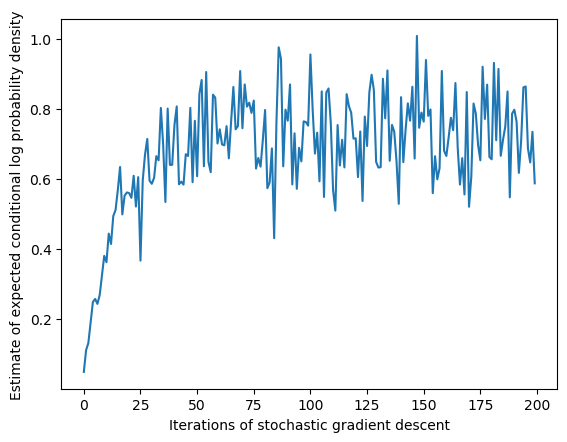

In [31]:
plot(scores)
xlabel("Iterations of stochastic gradient descent")
ylabel("Estimate of expected conditional log probability density");

### 4.5: Deep Learning based Data-Driven Proposals

Having previously relied on the power of gradient-based optimization we now seek to harness the representational capability of neural networks. To do so we have to parametrize the proposal with a deep neural network.

In [32]:
# sigmoid activation function for nonlinearity in the network
nonlinearity(x) = 1.7159 * tanh.(x * 0.66666);

Construct deep neural networks with two hidden layer for the x- and y-coordinates. Returns unnormalized probabilities.

In [33]:
# deep neural network for x
function dest_x_neural_net(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last]
    hidden_layer_1 = nonlinearity(W1 * input_layer .+ b1)
    hidden_layer_2 = nonlinearity(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
    return output_layer
end;

# deep neural network for y
function dest_y_neural_net(nn_params, x_first::Real, y_first::Real, x_last::Real, y_last::Real)
    (W1, b1, W2, b2, W3, b3) = nn_params
    input_layer = [x_first, y_first, x_last, y_last]#, dest_x]
    hidden_layer_1 = nonlinearity(W1 * input_layer .+ b1)
    hidden_layer_2 = nonlinearity(W2 * hidden_layer_1 .+ b2)
    output_layer = exp.(W3 * hidden_layer_2 .+ b3)
    return output_layer
end;

We are then able to define our new proposal distributions, which takes the two neural networks as priors on the x- and y-probabilities and then samples from the unaltered piecewise uniform distribution.

In [34]:
# scaling measure
scale_coord(coord, min, max) = (coord / (max - min)) - 0.5

# proposal distribution taking the neural networks as priors
@gen function custom_dest_proposal_neural(measurements::Vector{Point}, scene::Scene)
        
    @param x_W1::Matrix{Float64}
    @param x_b1::Vector{Float64}
    @param x_W2::Matrix{Float64}
    @param x_b2::Vector{Float64}
    @param x_W3::Matrix{Float64}
    @param x_b3::Vector{Float64}
    
    @param y_W1::Matrix{Float64}
    @param y_b1::Vector{Float64}
    @param y_W2::Matrix{Float64}
    @param y_b2::Vector{Float64}
    @param y_W3::Matrix{Float64}
    @param y_b3::Vector{Float64}
    
    num_x_bins = length(x_b3)
    num_y_bins = length(y_b3)
    
    # scale inputs to be in the range [-0.5, 0.5]
    x_first = scale_coord(measurements[1].x, scene.xmin, scene.xmax)
    x_last = scale_coord(measurements[end].x, scene.xmin, scene.xmax)
    y_first = scale_coord(measurements[1].y, scene.ymin, scene.ymax)
    y_last = scale_coord(measurements[end].y, scene.ymin, scene.ymax)
    
    # sample dest_x
    x_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_x_bins+1))
    x_probs = dest_x_neural_net((x_W1, x_b1, x_W2, x_b2, x_W3, x_b3), x_first, y_first, x_last, y_last)
    @trace(Gen.piecewise_uniform(x_bounds, x_probs / sum(x_probs)), :dest_x)
    
    # sample dest_y
    y_bounds = collect(range(scene.xmin, stop=scene.xmax, length=num_y_bins+1))
    y_probs = dest_y_neural_net((y_W1, y_b1, y_W2, y_b2, y_W3, y_b3), x_first, y_first, x_last, y_last)
    @trace(Gen.piecewise_uniform(y_bounds, y_probs / sum(y_probs)), :dest_y)
    
    return nothing
end;

Set the hyperparameters governing the width of the neural networks

In [35]:
num_hidden_1 = 50
num_hidden_2 = 50;

Initialize all parameters for both neural networks

In [37]:
import Random
Random.seed!(3)

init_weight(shape...) = (1. / sqrt(shape[2])) * randn(shape...)

init_x_W1 = init_weight(num_hidden_1, 4)
init_x_W2 = init_weight(num_hidden_2, num_hidden_1)
init_x_W3 = init_weight(num_x_bins, num_hidden_2)

# set parameters for dest_x_neural_net predictor network
init_param!(custom_dest_proposal_neural, :x_W1, init_x_W1)
init_param!(custom_dest_proposal_neural, :x_b1, zeros(num_hidden_1))
init_param!(custom_dest_proposal_neural, :x_W2, init_x_W2)
init_param!(custom_dest_proposal_neural, :x_b2, zeros(num_hidden_2))
init_param!(custom_dest_proposal_neural, :x_W3, init_x_W3)
init_param!(custom_dest_proposal_neural, :x_b3, zeros(num_x_bins))

init_y_W1 = init_weight(num_hidden_1, 4)
init_y_W2 = init_weight(num_hidden_2, num_hidden_1)
init_y_W3 = init_weight(num_x_bins, num_hidden_2)

# set parameters for dest_y_neural_net predictor network
init_param!(custom_dest_proposal_neural, :y_W1, init_y_W1)
init_param!(custom_dest_proposal_neural, :y_b1, zeros(num_hidden_1))
init_param!(custom_dest_proposal_neural, :y_W2, init_y_W2)
init_param!(custom_dest_proposal_neural, :y_b2, zeros(num_hidden_2))
init_param!(custom_dest_proposal_neural, :y_W3, init_y_W3)
init_param!(custom_dest_proposal_neural, :y_b3, zeros(num_y_bins));

Update the initial parameters with a stochastic gradient descent with a fixed step size of 0.001

In [38]:
update = Gen.ParamUpdate(Gen.FixedStepGradientDescent(0.001), custom_dest_proposal_neural);

100 epochs of training with each epoch needing about 1000 training examples and applying 100 gradient updates. At the end of each epoch we use 10000 samples to estimate the objective function. (This process takes some time)

In [39]:
@time scores = Gen.train!(custom_dest_proposal_neural, data_generator, update,
    num_epoch=100, epoch_size=1000, num_minibatch=100, minibatch_size=100,
    evaluation_size=1000, verbose=true);

epoch 1: generating 1000 training examples...
epoch 1: training using 100 minibatches of size 100...
epoch 1: evaluating on 1000 examples...
epoch 1: est. objective value: 0.6741937255629533
epoch 2: generating 1000 training examples...
epoch 2: training using 100 minibatches of size 100...
epoch 2: evaluating on 1000 examples...
epoch 2: est. objective value: 0.7205646354435988
epoch 3: generating 1000 training examples...
epoch 3: training using 100 minibatches of size 100...
epoch 3: evaluating on 1000 examples...
epoch 3: est. objective value: 0.6478114755576162
epoch 4: generating 1000 training examples...
epoch 4: training using 100 minibatches of size 100...
epoch 4: evaluating on 1000 examples...
epoch 4: est. objective value: 0.6677485463966828
epoch 5: generating 1000 training examples...
epoch 5: training using 100 minibatches of size 100...
epoch 5: evaluating on 1000 examples...
epoch 5: est. objective value: 0.6620751833819108
epoch 6: generating 1000 training examples...

epoch 43: evaluating on 1000 examples...
epoch 43: est. objective value: 1.1113200582524976
epoch 44: generating 1000 training examples...
epoch 44: training using 100 minibatches of size 100...
epoch 44: evaluating on 1000 examples...
epoch 44: est. objective value: 1.0857792684136827
epoch 45: generating 1000 training examples...
epoch 45: training using 100 minibatches of size 100...
epoch 45: evaluating on 1000 examples...
epoch 45: est. objective value: 1.1892236987088787
epoch 46: generating 1000 training examples...
epoch 46: training using 100 minibatches of size 100...
epoch 46: evaluating on 1000 examples...
epoch 46: est. objective value: 1.0907858961069514
epoch 47: generating 1000 training examples...
epoch 47: training using 100 minibatches of size 100...
epoch 47: evaluating on 1000 examples...
epoch 47: est. objective value: 1.08178600283883
epoch 48: generating 1000 training examples...
epoch 48: training using 100 minibatches of size 100...
epoch 48: evaluating on 100

epoch 85: est. objective value: 1.1588874686473185
epoch 86: generating 1000 training examples...
epoch 86: training using 100 minibatches of size 100...
epoch 86: evaluating on 1000 examples...
epoch 86: est. objective value: 1.1619015961052062
epoch 87: generating 1000 training examples...
epoch 87: training using 100 minibatches of size 100...
epoch 87: evaluating on 1000 examples...
epoch 87: est. objective value: 1.1713208101960513
epoch 88: generating 1000 training examples...
epoch 88: training using 100 minibatches of size 100...
epoch 88: evaluating on 1000 examples...
epoch 88: est. objective value: 1.1093044249487525
epoch 89: generating 1000 training examples...
epoch 89: training using 100 minibatches of size 100...
epoch 89: evaluating on 1000 examples...
epoch 89: est. objective value: 1.2383245378252423
epoch 90: generating 1000 training examples...
epoch 90: training using 100 minibatches of size 100...
epoch 90: evaluating on 1000 examples...
epoch 90: est. objective 

Assess the development of the log probability density

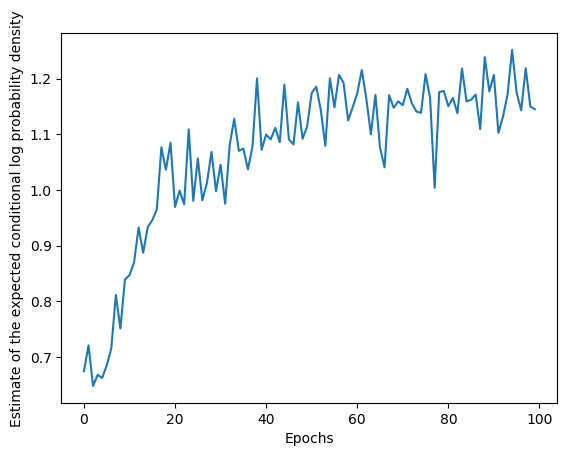

In [40]:
plot(scores)
xlabel("Epochs")
ylabel("Estimate of the expected conditional log probability density");

Which in its final throes achieves a better performance than a data-driven proposal, where only gradient-based optimization was deployed. What is quite apparent though is the stark constrast between the computational demands of the two approaches, i.e. 40 seconds vs 540 seconds. Which leads us to the trade-off at the core of a lot of inverse problems, uncertainty quantification, etc.; we have to decide how to best use our computational resources be it in a variational inference routine, where a variational family of distributions is optimized to approximate the "true" posterior distribution, but where the variational family can limit the representational capability or sampling-based routines, which require more computing power to arrive at an expressive posterior.

### List of References:

**Reference 1.** [An Introduction to Probabilistic Programming](https://arxiv.org/abs/1809.10756)

**Reference 2.** [Gen: A General-Purpose Probabilistic Programming System with Programmable Inference](https://dspace.mit.edu/bitstream/handle/1721.1/119255/MIT-CSAIL-TR-2018-020.pdf)

**Reference 3.** [Turing: A Language for Flexible Probabilistic Inference](https://dspace.mit.edu/bitstream/handle/1721.1/119255/MIT-CSAIL-TR-2018-020.pdf)

**Reference 4.** [Inference Compilation and Universal Probabilistic Programming](https://arxiv.org/abs/1610.09900)

**Reference 5.** [Etalumis: Bringing Probabilistic Programming to Scientific Simulators at Scale](https://arxiv.org/abs/1907.03382)